# Science4Cast
### A Machine Learning Challenge in the Science Of Science

### 目次:

1. [データの見方](#reading)
2. [データの可視化](#visualizing)
3. [学習データの作成](#train)
4. [モデルの学習](#baseline)
5. [評価](#metric)
6. [コンペのための評価](#testset)

### 要約
このコンペでは、次のデータが与えられる
- full_dynamic_graph_sparse：時刻t1までの動的グラフ（エッジとその作成日のリスト）
- unconnected_vertex_pairs：時刻t1までに接続されていない1,000,000個の頂点ペアのリスト

**コンペでのあなたの仕事**は、時間t2までunconnected_vertex_pairsのどのエッジが形成されるかを予測することです。 具体的には、unconnected_vertex_pairsの潜在的なエッジのリストを、最も可能性の高いものから最も可能性の低いものへと並べ替えます。結果は、ROC曲線のAUCを介して計算されます。

<a id='reading'></a>
## 1. データの見方

まず、下記からデータを取得できる [IARAI cloud](https://cloud.iarai.ac.at/index.php/s/iTx3bXgMdwsngPn)。三つのファイルを取得でき、内容は、下位の通りである。
- **TrainSet2014_3.pkl:** (33 MB) 2014年までのセマンティックネットワーク、およびニューラルネットワークのトレーニングのために予測できる未接続の頂点ペアのリスト
- **TrainSet2014_3_solution.pkl**: (0.5 MB) 2014年の接続されていない頂点ペアが2017年までに接続されているかどうかのソリューション
- **CompetitionSet2017_3.pkl**: (95 MB) 2017年までのセマンティックネットワーク、および評価のために予測する必要がある接続されていない頂点ペアのリスト

In [3]:
import pickle
import numpy as np

NUM_OF_VERTICES=64719 # セマンティックネットワークの頂点数
DATA_FILE_PATH="../../data/Science4Cast/"

data_source='TrainSet2014_3.pkl'
full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start,years_delta = pickle.load( open( DATA_FILE_PATH + data_source, "rb" ) )

print(data_source+' は '+str(len(full_dynamic_graph_sparse))+' 個のリンクを '+str(NUM_OF_VERTICES)+ ' 個の頂点間に持つ')
print('目的は、 '+str(len(unconnected_vertex_pairs))+' 個のunconnectedvertex-pairsの中から '+str(year_start+years_delta)+' 年までにリンクが繋がれるペアを予測することである ')

TrainSet2014_3.pkl は 2278611 個のリンクを 64719 個の頂点間に持つ
目的は、 1000000 個のunconnectedvertex-pairsの中から 2017 年までにリンクが繋がれるペアを予測することである 


 - **full_dynamic_graph_sparse:** 2014年または2017年までのセマンティックネットワーク全体。これはnumpy配列であり、各エントリはセマンティックネットワークのエッジを記述します。 各エッジは3つの数値[v1,v2,t]で表され、エッジは頂点v1とv2の間の時間tで形成されます。 tは、1990年1月1日からの日数で測定されます

- **unconnected_vertex_pairs:** これは、deg（v1）> = 10、deg（v2）> = 10の頂点ペアv1、v2のリストであり、2014年にはエッジが存在しません。ニューラルネットワークが解決する必要のある質問：エッジは形成されますか ？ 接続されていないすべての頂点が含まれているわけではなく、ランダムなサブセットが含まれています


- **year_start:** year_start=2014


- **years_delta:** years_delta=3

In [4]:
import random

random.seed(42)
print('Type of full_dynamic_graph_sparse: ', type(full_dynamic_graph_sparse))
print('\nExample edges:')
for idx in random.sample(range(len(full_dynamic_graph_sparse)), 5):
    print('Edge in semantic Net (edge #'+str(idx)+'): ', full_dynamic_graph_sparse[idx])

Type of full_dynamic_graph_sparse:  <class 'numpy.ndarray'>

Example edges:
Edge in semantic Net (edge #466956):  [35266 36996  7758]
Edge in semantic Net (edge #104902):  [32250 43887  6171]
Edge in semantic Net (edge #1153556):  [32538 47489  8465]
Edge in semantic Net (edge #1027150):  [13238 35059  8387]
Edge in semantic Net (edge #936213):  [ 1298 33622  8311]


1番目と2番目の数字は頂点のインデックスであり、3番目の数字はタイムスタンプを表します（1990年1月1日からの日数）

たとえば、最初のエントリである頂点35266と36996の間のエッジ＃466956は、1990年1月1日から7758日後に形成されました。<br>
64719の各頂点は、AIまたは機械学習の概念を表しています。（その意味は競技中に明らかにされません）<br>
概念が科学論文（具体的には、そのタイトルまたは要約）に同時に登場する場合、概念間にエッジが形成されます。

Next let's see *unconnected_vertex_pairs*:

In [5]:
for idx in random.sample(range(len(unconnected_vertex_pairs)), 5):
    print('Unconnected vertex pairs: ', unconnected_vertex_pairs[idx])

Unconnected vertex pairs:  [22768 11701]
Unconnected vertex pairs:  [13374  2149]
Unconnected vertex pairs:  [18646  3268]
Unconnected vertex pairs:  [12087 13432]
Unconnected vertex pairs:  [14672  1739]


2つのインデックスは、2つの頂点を表します。 これらの2つの頂点は、どちらも10より大きい次数を持っていますが、接続されていません。<br>
問題は、これらの概念のペア、たとえば（79、184）が3年後に接続されるかどうかです。

<a id='visualizing'></a>
## 2. データの可視化

[NetworkX](https://networkx.org/)を使用して、特定の時点でのセマンティックネットワークを視覚化できます。さらに便利なように、[SciPy](https://www.scipy.org/)を使用。<br>
100個のランダムな頂点を選択し、それらが2005、2008、2011、2014、および2017でどのように表示されるかを見ます。

まず、ランダムに選択された100個の頂点のみを使用してセマンティックネットワークからサブグラフを作成します。

In [6]:
from scipy import sparse
import networkx as nx

rnd_vertices=random.sample(range(100),50) # we use 50 random concepts

full_idx0=[]
full_idx1=[]
for ii in range(len(rnd_vertices)): # here we will find all indices of edges where the concept is either the first or the second vertex
    full_idx0=np.concatenate((full_idx0, np.where(full_dynamic_graph_sparse[:,0] == rnd_vertices[ii])[0]))
    full_idx1=np.concatenate((full_idx1, np.where(full_dynamic_graph_sparse[:,1] == rnd_vertices[ii])[0]))

all_idx=list(set(full_idx0) & set(full_idx1))

subgraph_of_semnet=full_dynamic_graph_sparse[np.array(all_idx).astype(int)] # get the corresponding edge

# These vertices have degree(v)>0, i.e. have at least one edge in the subgraph:
rnd_vertices=list(set(list(subgraph_of_semnet[:,0])+list(subgraph_of_semnet[:,1])))
print('Number of edges in the subgraph: ', len(subgraph_of_semnet))
print('Number of non-zero degree vertices in the subgraph: ', len(rnd_vertices))

print('For easier plotting, change names of vertices, from 0 to ', len(rnd_vertices))

print('5 edges of previous list:')
print(subgraph_of_semnet[0:5])
print('\n\n')

for ii in range(len(rnd_vertices)):
    subgraph_of_semnet[:,0]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,0]]
    subgraph_of_semnet[:,1]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,1]]

print('5 edges of new list:')
print(subgraph_of_semnet[0:5])


Number of edges in the subgraph:  288
Number of non-zero degree vertices in the subgraph:  43
For easier plotting, change names of vertices, from 0 to  43
5 edges of previous list:
[[  54   54 9067]
 [  54   54 8050]
 [  11   23 7732]
 [  11   75 8683]
 [   4   24 9114]]



5 edges of new list:
[[  24   24 9067]
 [  24   24 8050]
 [   4   10 7732]
 [   4   30 8683]
 [   2   11 9114]]


Next, let's create the subgraph at different times.

In [7]:
from datetime import date
day_origin = date(1990,1,1)
years=[2012,2013,2014]

all_nx_nets=[]

for yy in years:
    print('Create Graph for ', yy)
    day_curr=date(yy,12,31)
    all_edges_curr=subgraph_of_semnet[subgraph_of_semnet[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(len(rnd_vertices),len(rnd_vertices)))
    print('Number of edges: ',adj_mat_sparse_curr.getnnz())
    G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')
    
    all_nx_nets.append(G_curr)


Create Graph for  2012
Number of edges:  62
Create Graph for  2013
Number of edges:  92
Create Graph for  2014
Number of edges:  141


Network of the year  2012


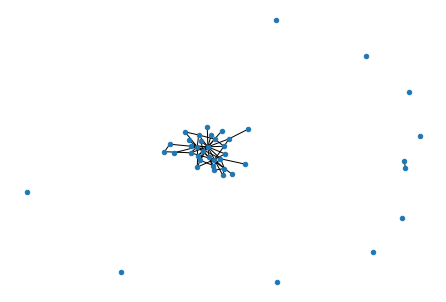

Network of the year  2013


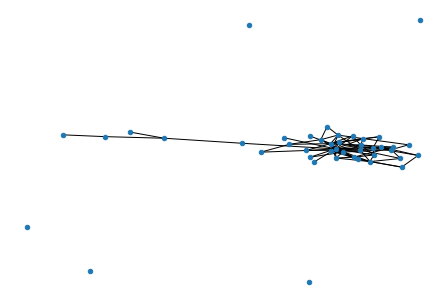

Network of the year  2014


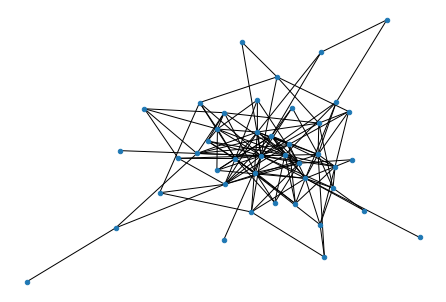

In [8]:
import matplotlib.pyplot as plt

for idx in range(len(all_nx_nets)):
    print('Network of the year ',years[idx])
    curr_net=all_nx_nets[idx]
    nx.draw(curr_net, pos=nx.spring_layout(curr_net), node_size=20)
    plt.show()

Number of edges in the subgraph:  723
Number of non-zero degree vertices in the subgraph:  353
For easier plotting, change names of vertices, from 0 to  353
Create Graph for  2012
Number of edges:  293
Create Graph for  2013
Number of edges:  411
Create Graph for  2014
Number of edges:  551
Network of the year  2012


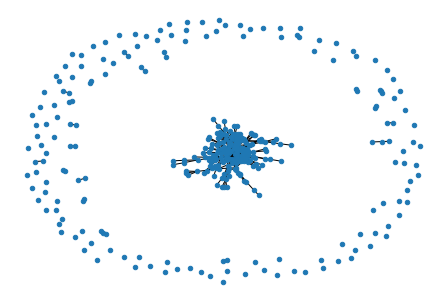

Network of the year  2013


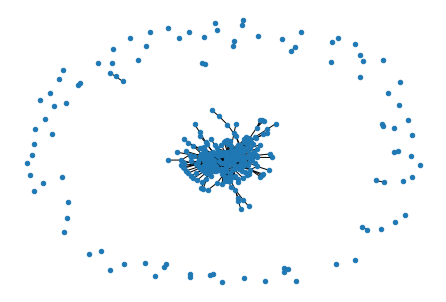

Network of the year  2014


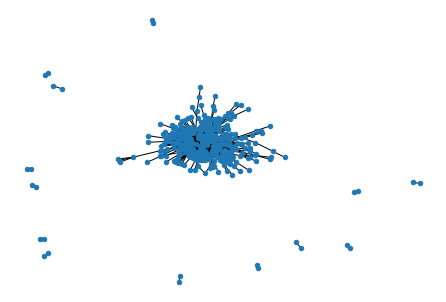

In [17]:
topic_num = 1000
rnd_vertices=random.sample(range(NUM_OF_VERTICES), topic_num) # we use 50 random concepts

full_idx0=[]
full_idx1=[]
for ii in range(len(rnd_vertices)): # here we will find all indices of edges where the concept is either the first or the second vertex
    full_idx0=np.concatenate((full_idx0, np.where(full_dynamic_graph_sparse[:,0] == rnd_vertices[ii])[0]))
    full_idx1=np.concatenate((full_idx1, np.where(full_dynamic_graph_sparse[:,1] == rnd_vertices[ii])[0]))

all_idx=list(set(full_idx0) & set(full_idx1))

subgraph_of_semnet=full_dynamic_graph_sparse[np.array(all_idx).astype(int)] # get the corresponding edge

# These vertices have degree(v)>0, i.e. have at least one edge in the subgraph:
rnd_vertices=list(set(list(subgraph_of_semnet[:,0])+list(subgraph_of_semnet[:,1])))
print('Number of edges in the subgraph: ', len(subgraph_of_semnet))
print('Number of non-zero degree vertices in the subgraph: ', len(rnd_vertices))

print('For easier plotting, change names of vertices, from 0 to ', len(rnd_vertices))

for ii in range(len(rnd_vertices)):
    subgraph_of_semnet[:,0]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,0]]
    subgraph_of_semnet[:,1]=[ii if x==rnd_vertices[ii] else x for x in subgraph_of_semnet[:,1]]

day_origin = date(1990,1,1)
years=[2012,2013,2014]

all_nx_nets=[]

for yy in years:
    print('Create Graph for ', yy)
    day_curr=date(yy,12,31)
    all_edges_curr=subgraph_of_semnet[subgraph_of_semnet[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(len(rnd_vertices),len(rnd_vertices)))
    print('Number of edges: ',adj_mat_sparse_curr.getnnz())
    G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')
    
    all_nx_nets.append(G_curr)



for idx in range(len(all_nx_nets)):
    print('Network of the year ',years[idx])
    curr_net=all_nx_nets[idx]
    nx.draw(curr_net, pos=nx.spring_layout(curr_net), node_size=20)
    plt.show()

<a id='train'></a>
## 3. 過去の訓練データの作成

次に、ベースラインモデルのトレーニングデータを作成します。 ベースラインモデルは、ニューラルネットワークの履歴(historic)状態を使用して、接続されていない頂点が接続されるかどうかを予測します。

検証の実行では、2014年のセマンティックネットを使用して2017年を予測します。したがって、2011年から2014年までのトレーニングデータを作成します。トレーニング後、2017年を予測できます。

In [9]:
import time

def create_training_data(full_graph,year_start,years_delta,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_matrix(adj_mat_sparse_curr, parallel_edges=False, create_using=None, edge_attribute='weight')

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('    Done: Create Graph for ', yy)
        print('    num of edges: ', G_curr.number_of_edges())

    all_degs=np.array(all_sparse[0].sum(0))[0]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    while len(unconnected_vertex_pairs)<edges_used:        
        v1,v2=random.sample(range(len(vertex_large_degs)), 2)

        if v1!=v2 and not all_G[0].has_edge(v1,v2):
            if len(unconnected_vertex_pairs)%10**6==0:
                time_end=time.time()
                print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                time_start=time.time()
            unconnected_vertex_pairs.append((v1,v2))
            unconnected_vertex_pairs_solution.append(all_G[1].has_edge(v1,v2))

        
    print('Number of unconnected vertex pairs for prediction: ', len(unconnected_vertex_pairs_solution))
    print('Number of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution))
    print('Ratio of vertex pairs that will be connected: ' , sum(unconnected_vertex_pairs_solution)/len(unconnected_vertex_pairs_solution))
    
    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))
    all_edge_list=np.array(all_edge_lists[0])
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution

edges_used=1*10**6 # Best would be to use all vertices, to create more training data. But that takes long and requires huge amount of memory. So here we use a random subset.
vertex_degree_cutoff=10
train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)

day_origin = date(1990,1,1)
years=[year_start-3,year_start-4,year_start-5]

train_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))

    train_sparse.append(adj_mat_sparse_curr)
print('done')

    Create Graph for  2011
    Done: Create Graph for  2011
    num of edges:  567750
    Create Graph for  2014
    Done: Create Graph for  2014
    num of edges:  1843253
    edge progress ( 6.008148193359375e-05 sec):  0.0 M/ 1.0 M
Number of unconnected vertex pairs for prediction:  1000000
Number of vertex pairs that will be connected:  329
Ratio of vertex pairs that will be connected:  0.000329
    Create Graph for  2011
    Create Graph for  2010
    Create Graph for  2009
done


<a id='baseline'></a>
## 4. Training a baseline model

Here we train a baseline model. The model uses hand-engineered features of the network, in a similar way as a previous [Semantic Network in Quantum Physics](https://www.pnas.org/content/117/4/1910).

### 4.1 Split data in training and testing
First, we split our data in training and testing.

In [13]:
print('    Shuffle training data...')
train_valid_test_size=[0.9, 0.1, 0.0]
x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

random.shuffle(x)
train_edges_for_checking = train_edges_for_checking[x]
train_edges_solution = train_edges_solution[x]

print('    Split dataset...')
idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

data_edges_train=train_edges_for_checking[0:idx_traintest]
solution_train=train_edges_solution[0:idx_traintest]  

data_edges_test=train_edges_for_checking[idx_traintest:]
solution_test=train_edges_solution[idx_traintest:]

print('Training, connected  : ',sum(solution_train==1))
print('Training, unconnected: ',sum(solution_train==0))

    Shuffle training data...
    Split dataset...
Training, connected  :  272
Training, unconnected:  899728


<a id='features'></a>
### 4.2 Creating features
ここでは、ベースラインモデルをトレーニングします。 このモデルは、以前の[量子物理学のセマンティックネットワーク](https://www.pnas.org/content/117/4/1910)と同様に、ネットワークの手作業で設計された機能を使用しています。

具体的には、頂点ペア（v1、v2）に15の機能を使用します。

**特徴：**
- 現在の年（2011年の検証時）および過去2年間のv1およびv2の情報。 （これらは6つのプロパティです）
- 現在の年（2011年の検証時）および過去2年間のv1とv2の合計での共通隣接ノードの数。 （これらは6つのプロパティです）
- 現在の年（2011年の検証時）および過去2年間のv1とv2の間の共通隣接ノードの数。 （これらは3つのプロパティです）

コンピューティング機能は高価であり、2つのクラス（接続されているものと接続されていないもの）は非常に不均一に分散しているため、トレーニングには接続されていない例の約1％しか使用しません。

In [14]:
def compute_all_properties(all_sparse,AA02,AA12,AA22,all_degs0,all_degs1,all_degs2,all_degs02,all_degs12,all_degs22,v1,v2):
    """
    Computes hand-crafted properties for one vertex in vlist
    """
    all_properties=[]

    all_properties.append(all_degs0[v1]) # 0
    all_properties.append(all_degs0[v2]) # 1
    all_properties.append(all_degs1[v1]) # 2
    all_properties.append(all_degs1[v2]) # 3
    all_properties.append(all_degs2[v1]) # 4
    all_properties.append(all_degs2[v2]) # 5
    all_properties.append(all_degs02[v1]) # 6
    all_properties.append(all_degs02[v2]) # 7
    all_properties.append(all_degs12[v1]) # 8
    all_properties.append(all_degs12[v2]) # 9
    all_properties.append(all_degs22[v1]) # 10
    all_properties.append(all_degs22[v2]) # 11

    all_properties.append(AA02[v1,v2]) # 12
    all_properties.append(AA12[v1,v2]) # 13
    all_properties.append(AA22[v1,v2]) # 14    

    return all_properties



def compute_all_properties_of_list(all_sparse,vlist):
    """
    Computes hand-crafted properties for all vertices in vlist
    """
    time_start=time.time()
    AA02=all_sparse[0]**2
    AA02=AA02/AA02.max()
    AA12=all_sparse[1]**2
    AA12=AA12/AA12.max()
    AA22=all_sparse[2]**2
    AA22=AA02/AA22.max()
    
    all_degs0=np.array(all_sparse[0].sum(0))[0]
    if np.max(all_degs0)>0:
        all_degs0=all_degs0/np.max(all_degs0)
        
    all_degs1=np.array(all_sparse[1].sum(0))[0]
    if np.max(all_degs1)>0:
        all_degs1=all_degs1/np.max(all_degs1)
    
    all_degs2=np.array(all_sparse[2].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs2=all_degs2/np.max(all_degs2)

    all_degs02=np.array(AA02[0].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs02=all_degs02/np.max(all_degs02)
        
    all_degs12=np.array(AA12[1].sum(0))[0]
    if np.max(all_degs12)>0:
        all_degs12=all_degs12/np.max(all_degs12)
        
    all_degs22=np.array(AA22[2].sum(0))[0]
    if np.max(all_degs22)>0:
        all_degs22=all_degs22/np.max(all_degs22)
    
    all_properties=[]
    print('    Computed all matrix squares, ready to ruuuumbleeee...')
    for ii in range(len(vlist)):
        vals=compute_all_properties(all_sparse,
                                    AA02,
                                    AA12,
                                    AA22,
                                    all_degs0,
                                    all_degs1,
                                    all_degs2,
                                    all_degs02,
                                    all_degs12,
                                    all_degs22,
                                    vlist[ii][0],
                                    vlist[ii][1])

        all_properties.append(vals)
        if ii%10**5==0:
            print('compute features: (',time.time()-time_start,'sec) ',ii/10**6,'M/',len(vlist)/10**6,'M')
            time_start=time.time()

    return all_properties

# Rather than using all connected and unconnected vertex pairs for training
# (i.e. needing to compute their properties), we reject about 99% of all unconnected
# examples, to have more examples of connected cases in the training. This significantly
# speeds up the computation, at the price of precision.
data_edges_train_smaller=[]
solution_train_smaller=[]
for ii in range(len(data_edges_train)):
    if (solution_train[ii]==0 and random.random()<0.01) or solution_train[ii]==1:
        data_edges_train_smaller.append(data_edges_train[ii])
        solution_train_smaller.append(solution_train[ii])

data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller)

data_train0=[]
data_train1=[]
for ii in range(len(data_edges_train_smaller)):
    if solution_train_smaller[ii]==1:
        data_train1.append(data_train[ii])
    else:
        data_train0.append(data_train[ii])

data_test=compute_all_properties_of_list(train_sparse,data_edges_test)
data_test0=[]
data_test1=[]
for ii in range(len(data_edges_test)):
    if solution_test[ii]==1:
        data_test1.append(data_test[ii])
    else:
        data_test0.append(data_test[ii])
print('done')

    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 4.3826940059661865 sec)  0.0 M/ 0.009245 M
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 4.13457989692688 sec)  0.0 M/ 0.1 M
done


<a id='nn'></a>
### 4.2 モデルの学習

次に、完全に接続された単純な3層ニューラルネットワークをトレーニングして、頂点ペアが接続されるかどうかを予測します。

0 - train:  1.758873 ; test:  1.7588751
50 - train:  1.2547339 ; test:  1.2547247
100 - train:  0.63799256 ; test:  0.6379651
150 - train:  0.49950105 ; test:  0.49946362
200 - train:  0.49848753 ; test:  0.4984417
250 - train:  0.49816728 ; test:  0.4981122
300 - train:  0.49785173 ; test:  0.4977855
350 - train:  0.4975286 ; test:  0.49745637
400 - train:  0.4972101 ; test:  0.4971292
450 - train:  0.49689835 ; test:  0.49680808
500 - train:  0.49658343 ; test:  0.49648488
550 - train:  0.49625385 ; test:  0.49614483
600 - train:  0.49592984 ; test:  0.49580994
650 - train:  0.49558896 ; test:  0.49545616
700 - train:  0.49524134 ; test:  0.49509573
750 - train:  0.49486917 ; test:  0.49471134
800 - train:  0.49448872 ; test:  0.49431968
850 - train:  0.49411377 ; test:  0.49393067
900 - train:  0.49369368 ; test:  0.49349743
950 - train:  0.4932639 ; test:  0.49305156
1000 - train:  0.4927873 ; test:  0.492558
1050 - train:  0.49226445 ; test:  0.4920131
1100 - train:  0.49169573 ; 

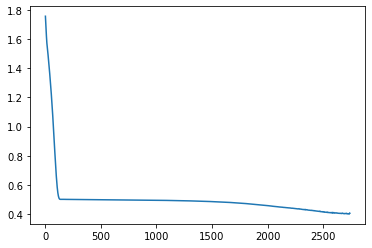

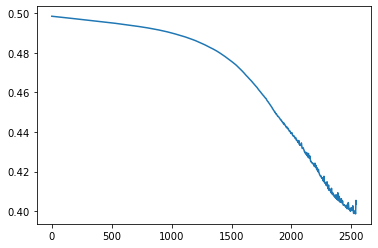

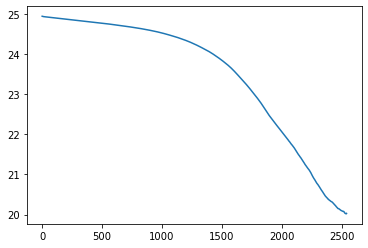

done


In [24]:
import torch
from torch import nn

class ff_network(nn.Module):

    def __init__(self):
        """
        Fully Connected layers
        """
        super(ff_network, self).__init__()

        self.semnet = nn.Sequential( # very small network for tests
            nn.Linear(15, 100), # 15 properties
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.ReLU(),       
            nn.Linear(100, 10),
            nn.ReLU(),             
            nn.Linear(10, 1)
        )


    def forward(self, x):
        """
        Pass throught network
        """
        res = self.semnet(x)

        return res


def train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size):
    """
    Training the neural network
    """    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    size_of_loss_check=2000
    
    optimizer_predictor = torch.optim.Adam(model_semnet.parameters(), lr=lr_enc)
    
    data_train0=torch.tensor(data_train0, dtype=torch.float).to(device)
    data_test0=torch.tensor(data_test0, dtype=torch.float).to(device)
    
    data_train1=torch.tensor(data_train1, dtype=torch.float).to(device)
    data_test1=torch.tensor(data_test1, dtype=torch.float).to(device)

    test_loss_total=[]
    moving_avg=[]
    criterion = torch.nn.MSELoss()
    
    # There are much more vertex pairs that wont be connected (0) rather than ones
    # that will be connected (1). However, we observed that training with an equally weighted
    # training set (same number of examples for (0) and (1)) results in more stable training.
    # (Imaging we have 1.000.000 nonconnected and 10.000 connected)
    #
    # For that reason, we dont have true 'episodes' (where each example from the training set
    # has been used in the training). Rather, in each of our iteration, we sample batch_size
    # random training examples from data_train0 and from data_train1.
    
    for iteration in range(10000): # should be much larger, with good early stopping criteria
        model_semnet.train()
        data_sets=[data_train0,data_train1]
        total_loss=0
        for idx_dataset in range(len(data_sets)):
            idx = torch.randint(0, len(data_sets[idx_dataset]), (batch_size,))
            data_train_samples = data_sets[idx_dataset][idx]
            calc_properties = model_semnet(data_train_samples)
            curr_pred=torch.tensor([idx_dataset] * batch_size, dtype=torch.float).to(device)
            curr_pred = curr_pred.unsqueeze(1)
            real_loss = criterion(calc_properties, curr_pred)
            total_loss += torch.clamp(real_loss, min = 0., max = 50000.).double()

        optimizer_predictor.zero_grad()
        total_loss.backward()
        optimizer_predictor.step()

        # Evaluating the current quality.
        with torch.no_grad():
            model_semnet.eval()
            # calculate train set
            eval_datasets=[data_train0,data_train1,data_test0,data_test1]
            all_real_loss=[]
            for idx_dataset in range(len(eval_datasets)):
                eval_datasets[idx_dataset]
                calc_properties = model_semnet(eval_datasets[idx_dataset][0:size_of_loss_check])        
                curr_pred = torch.tensor([idx_dataset%2] * len(eval_datasets[idx_dataset][0:size_of_loss_check]), dtype=torch.float).to(device)
                curr_pred = curr_pred.unsqueeze(1)
                real_loss = criterion(calc_properties, curr_pred)
                all_real_loss.append(real_loss.detach().cpu().numpy())
             
            test_loss_total.append(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))

            if iteration%50==0:
                print(str(iteration)+' - train: ',np.mean(all_real_loss[0])+np.mean(all_real_loss[1]),'; test: ',np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))


            if len(test_loss_total)>200: # early stopping
                test_loss_moving_avg=sum(test_loss_total[-50:])
                moving_avg.append(test_loss_moving_avg)
                if len(moving_avg)>10:
                    if moving_avg[-1]>moving_avg[-2] and moving_avg[-1]>moving_avg[-10]:
                        print('Early stopping kicked in')
                        break

    plt.plot(test_loss_total)
    plt.show()
    
    plt.plot(test_loss_total[200:])
    plt.show()    
    
    plt.plot(moving_avg)
    plt.show()

    return True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = ff_network().to(device)

batch_size=100 # Large batch_size seems to be important
lr_enc=5*10**-4

model_semnet.train()
train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size)  
print('done')

<a id='metric'></a>
## 5. モデルの評価（AUC）

トレーニング済みのモデルができたので、コンペの指標を使用してモデルの予測品質をテストする準備が整いました：[ROC曲線の曲線下面積（AUC）](https://en.wikipedia.org/wiki/Receiver_operating_characteristic＃Area_under_the_curve)。 このメトリックは、ノイズの影響を受けにくく、接続されたエッジと接続されていないエッジの分布に依存しないため、このメトリックを選択しました。

さらに、このタスクを解決するための非常に興味深い方法があるかもしれません。たとえば、直接[AUCを最大化する](https://towardsdatascience.com/explicit-auc-maximization-70beef6db14e)。

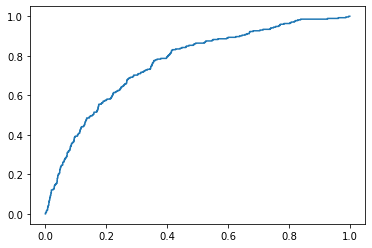

    AUC_train:  0.7641703705888572


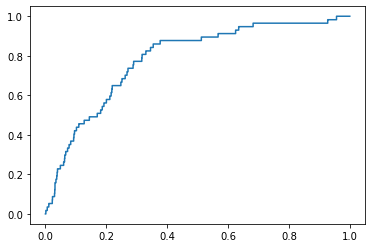

    AUC_test:  0.7848966893590364


In [16]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_ROC(data_vertex_pairs,data_solution):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    plt.plot(xpos, ypos)
    plt.show()
    
    AUC=sum(ROC_vals)/len(ROC_vals)
    return AUC

data_train=torch.tensor(data_train, dtype=torch.float).to(device)
all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0))    
AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller)
print('    AUC_train: ', AUC_train)

data_test=torch.tensor(data_test, dtype=torch.float).to(device)
all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))    
AUC_test=calculate_ROC(sorted_predictions_test, solution_test)
print('    AUC_test: ', AUC_test)

<a id='testset'></a>
## 6. コンペのための評価

次に、テストセットを分析します。 検証実行（2017を予測するための2014ネットワーク）または評価実行（2020を予測するための2017ネットワーク）の場合、手順は同じです。 ただ、1つのケースでは、AUCを計算でき、もう1つのケースでは、最終結果を保存して、コンテストに提出します。

どちらの場合も、*unconnected_vertex_pairs*内のすべての接続されていない頂点ペアの15個の特徴を計算します。

In [17]:
# Create properties for evaluation
print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+3)+' data.')
years=[year_start,year_start-1,year_start-2]

print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
eval_sparse=[]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix(
                                            (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                            shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                           )

    eval_sparse.append(adj_mat_sparse_curr)

print('    compute all properties for evaluation')
eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs)
eval_examples=np.array(eval_examples)

print('2.2) Uses the trained network to predict whether edges are created by '+str(year_start+3)+'.')
eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)
all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())

print('3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))   


2) Makes predictions for 2014 -> 2017 data.
2.1) Computes the 15 properties for the 2014 data.
    Create Graph for  2014
    Create Graph for  2013
    Create Graph for  2012
    compute all properties for evaluation
    Computed all matrix squares, ready to ruuuumbleeee...
compute features: ( 31.598323106765747 sec)  0.0 M/ 1.0 M
compute features: ( 5.7018420696258545 sec)  0.1 M/ 1.0 M
compute features: ( 5.401739835739136 sec)  0.2 M/ 1.0 M
compute features: ( 5.3491530418396 sec)  0.3 M/ 1.0 M
compute features: ( 5.322677850723267 sec)  0.4 M/ 1.0 M
compute features: ( 5.201218128204346 sec)  0.5 M/ 1.0 M
compute features: ( 5.387420892715454 sec)  0.6 M/ 1.0 M
compute features: ( 5.202871084213257 sec)  0.7 M/ 1.0 M
compute features: ( 5.160760879516602 sec)  0.8 M/ 1.0 M
compute features: ( 5.3900229930877686 sec)  0.9 M/ 1.0 M
2.2) Uses the trained network to predict whether edges are created by 2017.
3) Creates a sorted index list, from highest predicted vertex pair to least p

変数*sorted_predictions*が最終的な解決策です。 これにより、解決策がわかれば、AUCを再度計算できます。

- 検証用：ソリューションファイルをロードしてAUCを計算できます。
- コンペの評価用：jsonを使用してデータを保存し、Webサイトから送信できます。

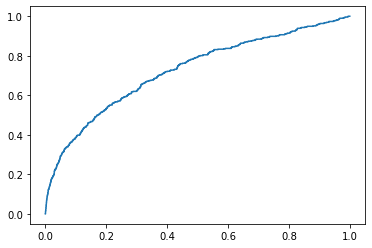

Area Under Curve for Evaluation:  0.724753239163579 





In [20]:
import json

if year_start==2017:
    # Save the results for submission.
    submit_file="model_all_idx"+str(year_start)+"_"+str(years_delta)+".json"
    all_idx_list_float=list(map(float, sorted_predictions_eval))
    with open(DATA_FILE_PATH +  submit_file, "w", encoding="utf8") as json_file:
        json.dump(all_idx_list_float, json_file)
    
    print("Solution stored as "+submit_file+".\nLooking forward to your submission.")        

else:
    with open(DATA_FILE_PATH + 'TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)
    
    AUC=calculate_ROC(sorted_predictions_eval, np.array(unconnected_vertex_pairs_solution))
    print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')